# Macroscopic Modeling of Multi-Lane Traffic Flow Dynamics

TODO

## Table of Content

1. [Data Cleaning](#1.-Data-Cleaning)
2. [Plotting Microscopic Data](#2.-Plotting-Microscopic-Data) <br />
   2.1 [Ring Road](#2.1-Ring-Road) <br />
   2.2 [Highway](#2.2-Highway)
3. [Plotting Macroscopic Data](#3.-Plotting-Macroscopic-Data) <br />
   3.1 [Ring Road](#3.1-Ring-Road) <br />
   3.2 [Highway](#3.2-Highway)
4. [Time-Frequency Analysis of Macroscopic Data](#4.-Time-Frequency-Analysis-of-Macroscopic-Data) <br />
   4.1 [Ring Road](#4.1-Ring-Road) <br />
   4.2 [Highway](#4.2-Highway)
5. [Modeling Results](#5.-Modeling-Results) <br />
   5.1 [Lighthill-Whitham-Richards (LWR) Model](#5.1-Lighthill-Whitham-Richards-(LWR)-Model) <br />
   5.2 [Aw-Rascle-Zhang (ARZ) Model](#5.2-Aw-Rascle-Zhang-(ARZ)-Model) <br />
   5.3 [Linearized ARZ Model](#5.3-Linearized-ARZ-Model) <br />
   5.4 [Non-Local Model](#5.4-Non-Local-Model) <br />
   5.5 [Fully-Connected Neural Network](#5.5-Fully-Connected-Neural-Network)

## 1. Data Cleaning

We begin by performing some data cleaning. Sumo simulations within Flow generate emission csv files with several datapoints. For our purposes, we only care about the following:

* time: the timestamp of the given sample
* id: the name of the vehicle associated with this sample
* relative_position: the position of the vehicle on a given edge
* speed: the speed of the vehicle
* edge_id: the edge the vehicle is current residing on
* lane_number: the lane index of the vehicle, starting from 0 on the rightmost lane

Therefore, in order to reduce the size of the generate files, the below script trims out any unnecesary columns.

In [ ]:
import pandas as pd
import os

# Specify the network type.
RING    = True
MERGE   = False
HIGHWAY = False

# Specify the directories containing the files you'd like to clean.
directory = ["data/ring-3-lanes/baseline/sumo-free/150",
             "data/ring-3-lanes/baseline/sumo-free/165",
             "data/ring-3-lanes/baseline/sumo-free/180",
             "data/ring-3-lanes/baseline/sumo-free/195",
             "data/ring-3-lanes/baseline/sumo-free/210",
             "data/ring-3-lanes/baseline/sumo-free/225"]


for directory_i in directory:
    # get the names of all files in the directory
    files = os.listdir(directory_i)
    files.remove("micro")
    files.remove("macro")

    for i, fp in enumerate(sorted(files)):
        # import the next file
        df = pd.read_csv(os.path.join(directory_i, fp))

        # keep only the datapoints we care about
        df = df[["time", "id", "relative_position", "speed", "edge_id", "lane_number"]]

        if MERGE:
            df = df[(df.edge_id == 'inflow_highway')
                    | (df.edge_id =='left')
                    | (df.edge_id == 'center')
                    | (df.edge_id == ':center_0')
                    | (df.edge_id == ':center_1')]

        # save the new dataframe under the path micro/{i}.csv
        df.to_csv(os.path.join(directory_i, 'micro/{}.csv'.format(i)), index=False)

        # delete the dataframe
        del df

Next, we use the *edge_id* and *relative_position* data to generate global positions for each of the vehicles in the network, which we store under a new *global_position* attribute. The subsequent datapoints are removed, as they are no longer needed.

We begin by defining an absolute position term for the starting position of each edge on the network. This is defined in the `edgestarts` variable by the cell below. We do this for the ring road and highway networks. Modify the capitalized variable at the start of the cell to match the network you are using.

In [ ]:
# specify the network type
RING    = True
MERGE   = False
HIGHWAY = False

# length of the ring road
RING_LENGTH = 1500

# length of the highway
MERGE_LENGTH = 1500

# position on the on-ramp merge on the highway
MERGE_POS = 1200


if RING:
    # length of inter-edge junctions
    junction_length = 0.1

    edgestarts = {
        "bottom": 0,
        ":right_0": 0.25 * RING_LENGTH,
        "right": 0.25 * RING_LENGTH + junction_length,
        ":top_0": 0.5 * RING_LENGTH + junction_length,
        "top": 0.5 * RING_LENGTH + 2 * junction_length,
        ":left_0": 0.75 * RING_LENGTH + 2 * junction_length,
        "left": 0.75 * RING_LENGTH + 3 * junction_length,
        ":bottom_0": RING_LENGTH + 3 * junction_length
    }

if MERGE:
    # import network data from flow params
    inflow_edge_len = 100
    premerge = MERGE_POS - inflow_edge_len
    postmerge = MERGE_LENGTH - MERGE_POS

    # generate edge starts
    edgestarts = {
        'inflow_highway': 0,
        'left': inflow_edge_len + 0.1,
        'center': inflow_edge_len + premerge + 22.6,
        'inflow_merge': inflow_edge_len + premerge + postmerge + 22.6,
        'bottom': 2 * inflow_edge_len + premerge + postmerge + 22.7,
        ':left_0': inflow_edge_len,
        ':center_0': inflow_edge_len + premerge + 0.1,
        ':center_1': inflow_edge_len + premerge + 0.1,
        ':bottom_0': 2 * inflow_edge_len + premerge + postmerge + 22.6
    }

if HIGHWAY:
    pass  # TODO

The below cell then performs the operation of adding global positions.

In [ ]:
import pandas as pd
import os

directory = ["data/ring-3-lanes/baseline/sumo-free/150/micro",
             "data/ring-3-lanes/baseline/sumo-free/165/micro",
             "data/ring-3-lanes/baseline/sumo-free/180/micro",
             "data/ring-3-lanes/baseline/sumo-free/195/micro",
             "data/ring-3-lanes/baseline/sumo-free/210/micro",
             "data/ring-3-lanes/baseline/sumo-free/225/micro"
]


for directory_i in directory:
    # get the names of all files in the directory
    files = os.listdir(directory_i)

    for fp in files:
        print(directory_i, fp)
        # import the next file
        df = pd.read_csv(os.path.join(directory_i, fp))

        # create a column for the global positions
        df["global_position"] = 0

        # add the global position of the start of the edge
        for key in edgestarts.keys():
            df.loc[df.edge_id == key, "global_position"] = edgestarts[key]

        # add the relative position of the vehicles on the edge
        df.global_position += df.relative_position

        # remove the relative_position and edge_id columns
        df = df[["time", "id", "global_position", "speed", "lane_number"]]

        # save the new dataframe under the path i.csv
        df.to_csv(os.path.join(directory_i, fp), index=False)

        # delete the dataframe
        del df

Finally, the below script generates meaningful macroscopic measurements from the available microscopic files. This is done by aggregates the densities and average speeds for sections of length `DX`. These aggregates can be collected for each lane separately by setting `INDIVIDUAL_LANES` to True.

In [2]:
import numpy as np
import pandas as pd
import os
import csv
import time

# the discretization in space for the aggregation procedure
DX = 50

# the total length of the network
LENGTH = 1500

# whether to compute the speeds and densities for each lane separately
INDIVIDUAL_LANES = False

# Specify the directories containing the files you'd like to compute 
# macroscopic properties for.
directory = ["data/ring-2-lanes/baseline/sumo-free/100",
             "data/ring-2-lanes/baseline/sumo-free/110",
             "data/ring-2-lanes/baseline/sumo-free/120",
             "data/ring-2-lanes/baseline/sumo-free/130",
             "data/ring-2-lanes/baseline/sumo-free/140",
             "data/ring-2-lanes/baseline/sumo-free/150"]


for directory_i in directory:
    directory_micro = os.path.join(directory_i, "micro")
    directory_macro = os.path.join(directory_i, "macro")

    # get the names of all files in the directory
    files = os.listdir(directory_micro)

    for i, fp in enumerate(sorted(files)):
        # for timing purposes
        print(directory_i, i)
        t0 = time.time()

        # import the next file
        df = pd.read_csv(os.path.join(directory_micro, fp))
        times = sorted(list(np.unique(df.time)))
        speeds = []
        densities = []
        all_times = np.array(df.time)
        all_speeds = np.array(df.speed)
        all_positions = np.array(df.global_position)

        for t in times:
            densities_t = []
            speeds_t = []
            for x in range(round(LENGTH/DX)):
                indx = np.logical_and(
                    all_times == t,
                    np.logical_and(
                        DX * x <= all_positions,
                        all_positions < DX * (x+1)
                    )
                )

                # compute the speeds and densities
                if INDIVIDUAL_LANES:
                    # compute the number of individual lanes in the data
                    num_lanes = len(np.unique(df.lane_number))

                    # placeholders for the generated data
                    speeds = [[] for _ in range(num_lanes)]
                    densities = [[] for _ in range(num_lanes)]

                    pass # TODO
                else:
                    speeds_tx = all_speeds[indx]
                    num_vehicles = len(speeds_tx)

                    densities_t.append(num_vehicles / DX)
                    speeds_t.append(np.mean(speeds_tx) if num_vehicles != 0 else 0)

            speeds.append(speeds_t)
            densities.append(densities_t)

        # place the new data in an output dictionary
        speeds = np.asarray(speeds)
        densities = np.asarray(densities)
        num_sections = speeds.shape[1]
        output = {"time": times}
        output.update({"speed_{}".format(j): list(speeds[:, j]) for j in range(num_sections)})
        output.update({"density_{}".format(j): list(densities[:, j]) for j in range(num_sections)})

        # store in a csv file
        with open(os.path.join(directory_macro, "{}.csv".format(i)), "w") as outfile:
            writer = csv.writer(outfile)
            writer.writerow(output.keys())
            writer.writerows(zip(*output.values()))

        print(" Done: {} sec".format(time.time() - t0))

data/ring-2-lanes/baseline/sumo-free/120 40
 Done: 395.103394985199 sec
data/ring-2-lanes/baseline/sumo-free/120 41
 Done: 380.1697859764099 sec
data/ring-2-lanes/baseline/sumo-free/120 42
 Done: 385.55381870269775 sec
data/ring-2-lanes/baseline/sumo-free/120 43
 Done: 383.1254949569702 sec
data/ring-2-lanes/baseline/sumo-free/120 44
 Done: 379.05645418167114 sec
data/ring-2-lanes/baseline/sumo-free/120 45
 Done: 381.96687269210815 sec
data/ring-2-lanes/baseline/sumo-free/120 46
 Done: 370.9573268890381 sec
data/ring-2-lanes/baseline/sumo-free/120 47
 Done: 376.4099705219269 sec
data/ring-2-lanes/baseline/sumo-free/120 48
 Done: 387.1089024543762 sec
data/ring-2-lanes/baseline/sumo-free/120 49
 Done: 382.97861075401306 sec
data/ring-2-lanes/baseline/sumo-free/130 0
 Done: 422.16307616233826 sec
data/ring-2-lanes/baseline/sumo-free/130 1
 Done: 424.9447853565216 sec
data/ring-2-lanes/baseline/sumo-free/130 2
 Done: 417.67887592315674 sec
data/ring-2-lanes/baseline/sumo-free/130 3
 Done:

 Done: 544.1026871204376 sec
data/ring-2-lanes/baseline/sumo-free/150 3
 Done: 543.5093445777893 sec
data/ring-2-lanes/baseline/sumo-free/150 4
 Done: 543.4088451862335 sec
data/ring-2-lanes/baseline/sumo-free/150 5
 Done: 541.6058893203735 sec
data/ring-2-lanes/baseline/sumo-free/150 6
 Done: 543.8978471755981 sec
data/ring-2-lanes/baseline/sumo-free/150 7
 Done: 544.9568057060242 sec
data/ring-2-lanes/baseline/sumo-free/150 8
 Done: 539.0438230037689 sec
data/ring-2-lanes/baseline/sumo-free/150 9
 Done: 536.5281095504761 sec
data/ring-2-lanes/baseline/sumo-free/150 10
 Done: 542.1876230239868 sec
data/ring-2-lanes/baseline/sumo-free/150 11
 Done: 542.7659206390381 sec
data/ring-2-lanes/baseline/sumo-free/150 12
 Done: 543.9142661094666 sec
data/ring-2-lanes/baseline/sumo-free/150 13
 Done: 548.2705481052399 sec
data/ring-2-lanes/baseline/sumo-free/150 14
 Done: 546.8172521591187 sec
data/ring-2-lanes/baseline/sumo-free/150 15
 Done: 545.6913850307465 sec
data/ring-2-lanes/baseline/su

## 2. Plotting Microscopic Data

We provide some supplementary methods for plotting time-space diagrams from the cleaned microscopic data. These plots are in many ways visually similar to the flow/density plots in the next section.

The below method is heavily adopted from this [link](https://github.com/flow-project/flow/blob/master/flow/visualize/time_space_diagram.py).

In [3]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.colors as colors


def time_space_diagram(df, 
                       lane=0, 
                       min_speed=0, 
                       max_speed=30, 
                       discontinuity=10,
                       title="Time-Space Diagram",
                       save_path=None):
    # leave only lane-relevant data
    df = df[df.lane_number == lane]

    # extract some variables from the dataset
    times = sorted(list(np.unique(df.time)))
    num_times = len(times)
    vehicles = sorted(list(np.unique(df.id)))
    num_vehicles = len(vehicles)

    # empty arrays for the positions and speeds of all vehicles
    pos = np.zeros((num_times, num_vehicles))
    speed = np.zeros((num_times, num_vehicles))

    # prepare the speed and absolute position in a way that is compatible with
    # the space-time diagram, and compute the number of vehicles at each step
    for j, veh_id in enumerate(vehicles):
        df_j = df[df.id == veh_id]
        pos_j = np.asarray(df_j.global_position)
        speed_j = np.asarray(df_j.speed)
        vehicle_times = np.asarray(df_j.time)
        for k, vehicle_time in enumerate(vehicle_times):
            index = times.index(vehicle_time)
            pos[index, j] = pos_j[k]
            speed[index, j] = speed_j[k]

    # some plotting parameters
    cdict = {
        'red': ((0, 0, 0), (0.2, 1, 1), (0.6, 1, 1), (1, 0, 0)),
        'green': ((0, 0, 0), (0.2, 0, 0), (0.6, 1, 1), (1, 1, 1)),
        'blue': ((0, 0, 0), (0.2, 0, 0), (0.6, 0, 0), (1, 0, 0))
    }
    my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    # perform plotting operation
    fig = plt.figure(figsize=(16, 9))
    ax = plt.axes()
    norm = plt.Normalize(min_speed, max_speed)
    cols = []

    xmin = times[0]
    xmax = times[-1]
    xbuffer = (xmax - xmin) * 0.025  # 2.5% of range
    ymin, ymax = np.amin(pos), np.amax(pos)
    ybuffer = (ymax - ymin) * 0.025  # 2.5% of range

    ax.set_xlim(xmin - xbuffer, xmax + xbuffer)
    ax.set_ylim(ymin - ybuffer, ymax + ybuffer)

    for indx_car in range(pos.shape[1]):
        unique_car_pos = pos[:, indx_car]

        # discontinuity from wraparound
        disc = np.where(np.abs(np.diff(unique_car_pos)) >= discontinuity)[0] + 1
        unique_car_time = np.insert(times, disc, np.nan)
        unique_car_pos = np.insert(unique_car_pos, disc, np.nan)
        unique_car_speed = np.insert(speed[:, indx_car], disc, np.nan)

        points = np.array(
            [unique_car_time, unique_car_pos]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        lc = LineCollection(segments, cmap=my_cmap, norm=norm)

        # Set the values used for color mapping
        lc.set_array(unique_car_speed)
        lc.set_linewidth(1.75)
        cols.append(lc)

    plt.title(title, fontsize=25)
    plt.ylabel('Position (m)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)

    for col in cols:
        line = ax.add_collection(col)
    cbar = plt.colorbar(line, ax=ax)
    cbar.set_label('Velocity (m/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)

    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

### 2.1 Ring Road

TODO

In [4]:
LANES = 2

for n_vehicles in [50, 55, 60, 65, 70, 75]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/ring-2-lanes/baseline/sumo-free/{}/micro/{}.csv".format(LANES * n_vehicles, i)
        df = pd.read_csv(fp)

        for lane in range(LANES):
            time_space_diagram(
                df,
                lane,
                min_speed=0,
                max_speed=30,
                title="",
                discontinuity=20,
                save_path=os.path.join(fp.rsplit('/', 1)[0], "ts-{}-{}.png".format(i, lane))
            )

/home/nier/.local/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


### 2.2 Merge

TODO

In [16]:
LANES = 1

for inflow in [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/merge-1-lane/baseline/sumo-idm/{}/micro/{}.csv".format(LANES * inflow, i)
        df = pd.read_csv(fp)

        for lane in range(LANES):
            time_space_diagram(
                df,
                lane,
                min_speed=0,
                max_speed=30,
                title="",
                discontinuity=20,
                save_path=os.path.join(fp.rsplit('/', 1)[0], "ts-{}-{}.png".format(i, lane))
            )

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f8ad45e2a60> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f8ad42d6a60> (for post_execute):


KeyboardInterrupt: 

### 2.3 Highway

TODO

## 3. Plotting Macroscopic Data

We provide auxiliary methods for plotting the macroscopic traffic flow properties (i.e. flows and densities) from output files generating during the data cleaning procedure above. Examples of these plotting methods in action are available in the following subsections.

In [5]:
import pandas as pd
import numpy as np
import os


def avg_speed_plot(dir_path, sub_paths):
    # get the times from the first dataframe
    df = pd.read_csv(os.path.join(dir_path, "{}/micro/0.csv".format(sub_paths[0])))
    times = sorted(list(np.unique(df.time)))

    # empty arrays for the average speeds of all vehicles
    avg_speed = [[] for _ in range(len(sub_paths))]

    for i, path in enumerate(sub_paths):
        # extract the ".csv" file names
        filenames = os.listdir(os.path.join(dir_path, "{}/micro".format(path)))
        filenames = [fp for fp in filenames if fp.endswith(".csv")]

        for fp in filenames:
            print(path, fp)
            # get the dataframe
            full_path = os.path.join(dir_path, "{}/micro/{}".format(path, fp))
            df = pd.read_csv(full_path)

            avg_speeds_i = []
            for t in times:
                df_t = df[df.time==t]
                avg_speeds_i.append(np.mean(df_t.speed))

            avg_speed[i].append(avg_speeds_i)

        avg_speed[i] = np.array(avg_speed[i])        

    labels = sub_paths
    colors = plt.cm.get_cmap('tab10', len(labels)+1)
    fig = plt.figure(figsize=(16, 9))
    for i, (label, result) in enumerate(zip(labels, avg_speed)):
        plt.plot(times, np.mean(result, 0),
                 color=colors(i), linewidth=2, label=label)
        plt.fill_between(times,
                         np.mean(result, 0) - np.std(result, 0),
                         np.mean(result, 0) + np.std(result, 0),
                         alpha=0.25, color=colors(i))

    plt.ylabel('Velocity (m/s)', fontsize=20)
    plt.xlabel('Time (s)', fontsize=20)
    plt.tick_params(labelsize=15)
    plt.legend(fontsize=20)


def flow_density_plot(df, 
                      total_time,
                      length,
                      min_speed=0,
                      max_speed=30,
                      min_density=0,
                      max_density=0.2,
                      speed_save_path=None,
                      density_save_path=None,
                      flow_save_path=None):
    # some plotting parameters
    cdict = {
        'red': ((0, 0, 0), (0.2, 1, 1), (0.6, 1, 1), (1, 0, 0)),
        'green': ((0, 0, 0), (0.2, 0, 0), (0.6, 1, 1), (1, 1, 1)),
        'blue': ((0, 0, 0), (0.2, 0, 0), (0.6, 0, 0), (1, 0, 0))
    }
    my_cmap = colors.LinearSegmentedColormap('my_colormap', cdict, 1024)

    speed_columns = [c for c in df.columns if c.startswith("speed")]
    a = np.asarray(df[speed_columns]).T

    density_columns = [c for c in df.columns if c.startswith("density")]
    b = np.asarray(df[density_columns]).T

    c = a * b * 3600

    # Plot the average speed plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_speed, max_speed)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(a, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Velocity (m/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if speed_save_path is not None:
        plt.savefig(speed_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()
    
    # Plot the density plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_density, max_density)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(b, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('Density (veh/s)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if density_save_path is not None:
        plt.savefig(density_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

    # Plot the flow plots.
    plt.figure(figsize=(16,9))
    norm = plt.Normalize(min_speed * min_density * 3600, 0.2 * max_speed * max_density * 3600)
    plt.xlabel("Time (s)", fontsize=20)
    plt.ylabel("Position (m)", fontsize=20)
    plt.imshow(c, extent=(0,total_time,0,length), origin='lower', aspect='auto', cmap=my_cmap, norm=norm)
    cbar = plt.colorbar()
    cbar.set_label('flow (veh/hr)', fontsize=20)
    cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)

    if flow_save_path is not None:
        plt.savefig(flow_save_path, bbox_inches='tight')
    plt.clf()
    plt.close()

### 3.1 Ring Road

TODO

100 44.csv
100 22.csv
100 23.csv
100 12.csv
100 46.csv
100 43.csv
100 29.csv
100 14.csv
100 10.csv
100 0.csv
100 13.csv
100 35.csv
100 4.csv
100 45.csv
100 9.csv
100 48.csv
100 18.csv
100 25.csv
100 33.csv
100 2.csv
100 32.csv
100 7.csv
100 42.csv
100 26.csv
100 34.csv
100 16.csv
100 11.csv
100 40.csv
100 15.csv
100 21.csv
100 30.csv
100 39.csv
100 20.csv
100 31.csv
100 1.csv
100 3.csv
100 47.csv
100 8.csv
100 37.csv
100 28.csv
100 19.csv
100 17.csv
100 38.csv
100 27.csv
100 24.csv
100 6.csv
100 5.csv
100 49.csv
100 36.csv
100 41.csv
110 44.csv
110 22.csv
110 23.csv
110 12.csv
110 46.csv
110 43.csv
110 29.csv
110 14.csv
110 10.csv
110 0.csv
110 13.csv
110 35.csv
110 4.csv
110 45.csv
110 9.csv
110 48.csv
110 18.csv
110 25.csv
110 33.csv
110 2.csv
110 32.csv
110 7.csv
110 42.csv
110 26.csv
110 34.csv
110 16.csv
110 11.csv
110 40.csv
110 15.csv
110 21.csv
110 30.csv
110 39.csv
110 20.csv
110 31.csv
110 1.csv
110 3.csv
110 47.csv
110 8.csv
110 37.csv
110 28.csv
110 19.csv
110 17.csv
110 38

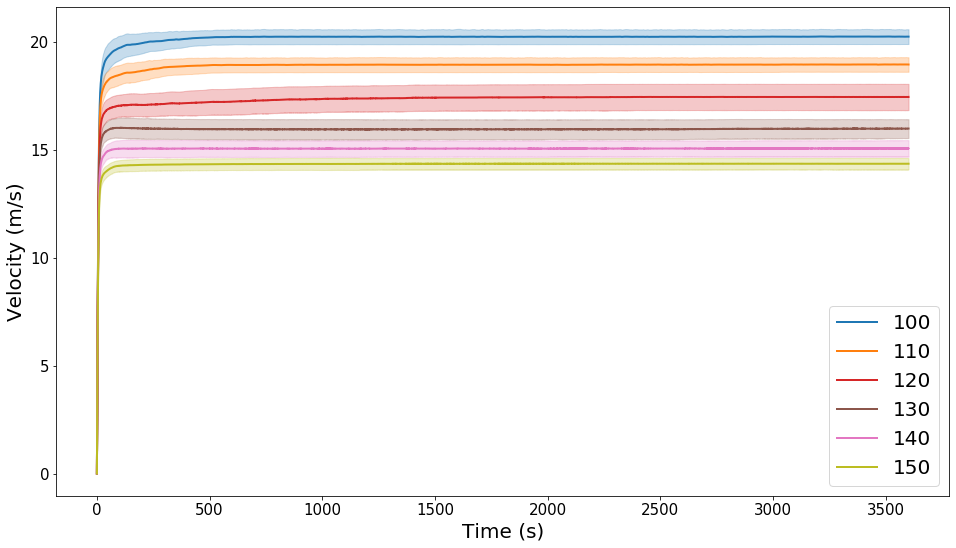

In [7]:
# modify this path to match the dataset
DIR_PATH = "data/ring-2-lanes/baseline/sumo-free"
SUB_PATHS = ["100", "110", "120", "130", "140", "150"]

a = avg_speed_plot(DIR_PATH, SUB_PATHS)

In [6]:
LANES = 2

for n_vehicles in [50, 55, 60, 65, 70, 75]:
    for i in range(50):
        # modify this path to match the dataset
        fp = "data/ring-2-lanes/baseline/sumo-free/{}/macro/{}.csv".format(LANES * n_vehicles, i)
        df = pd.read_csv(fp)

        flow_density_plot(
            df, 
            total_time=3600,
            length=1500,
            speed_save_path=os.path.join(fp.rsplit('/', 1)[0], "speed-{}.png".format(i)),
            density_save_path=os.path.join(fp.rsplit('/', 1)[0], "density-{}.png".format(i)),
            flow_save_path=os.path.join(fp.rsplit('/', 1)[0], "flow-{}.png".format(i))
        )

### 3.2 Merge

TODO

### 3.3 Highway

TODO

## 4. Time-Frequency Analysis of Macroscopic Data

TODO

### 4.1 Ring Road

TODO

### 4.2 Highway

TODO

## 5. Modeling Results

TODO

### 5.1 Lighthill-Whitham-Richards (LWR) Model

TODO

### 5.2 Aw-Rascle-Zhang (ARZ) Model

TODO

### 5.3 Linearized ARZ Model

TODO

### 5.4 Non-Local Model

TODO

### 5.5 Fully-Connected Neural Network

TODO